In [2]:
# importing the requests library
import requests
from datetime import datetime
import json
import time 
import pandas as pd
from tqdm.notebook import tqdm_notebook
from flatten_json import flatten
import numpy as np 


import matplotlib.pyplot as plt
color_map = plt.cm.winter
from matplotlib.patches import RegularPolygon
import math
from PIL import Image
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors

API_URL = 'https://statsapi.web.nhl.com/api/v1/'

In [3]:
# NHL-api-endpoints of use
seasons_url = 'seasons'
games_schedule_of_season_url = 'schedule?season={}&gameType={}'
game_events_url = 'game/{}/feed/live'
game_types = ['R', 'P']


In [4]:
# #GAME TYPES
# game_types_response = requests.get(url = API_URL + gameTypes)#get the seasons' details eg. #games played
# # extracting data in json format
# game_types = game_types_response.json()

In [5]:
#SEASON DETAILS
seasons_response = requests.get(url = API_URL + seasons_url)
seasons = seasons_response.json()['seasons']
# games_played_all_seasons = []
season_ids = []
for season in seasons:
    season_end_date_year = datetime.strptime(season['seasonEndDate'], '%Y-%m-%d').date().year
    if(season_end_date_year > 2019):
#         games_played_current_season = {}
#         games_played_current_season['seasonId'] = season['seasonId']
#         games_played_current_season['numberOfGames'] = season['numberOfGames']
#         games_played_all_seasons.append(games_played_current_season)
        season_ids.append(season['seasonId'])
print(season_ids)

['20192020', '20202021', '20212022']


In [6]:
#get game IDs from the scheulde to fetch the actual events of the game
# {
#     game_Date : [{home_team: val1, away_team: val2, game_id: val3, winner: val4, }, {}]
#     #array coz there are multiple games on the same day 
# }

season_id_to_game_ids = {} #{20192020: [1,2,3]}
game_ids = []
for season_id in season_ids:
    for game_type in game_types:
        season_games_schedule_url = API_URL+games_schedule_of_season_url.format(season_id, game_type)
        #https://statsapi.web.nhl.com/api/v1/schedule?season=20182019&gameType=R
        schedule_details_response = requests.get(url = season_games_schedule_url)
        schedule_details_dates = schedule_details_response.json()['dates']
        for schedule_details_date in schedule_details_dates:
            scheduled_games = schedule_details_date["games"]
            for scheduled_game in scheduled_games:
                if season_id not in season_id_to_game_ids:
                    season_id_to_game_ids[season_id] = []
                season_id_to_game_ids[season_id].append(scheduled_game['gamePk'])
                game_ids.append(scheduled_game['gamePk']) 
                #this is just game ids that we need to use to get the events
                
print(len(season_id_to_game_ids['20202021']))

952


## OLD CODE. KEEP AS BACKUP BUT FOR DIFFERENT JSON STRUCTURE

In [6]:
# # important storage design here
# #thi show how Team_A has scored against Team_B across all the matches
# # {
# #     Teams_A : {
# #                 Team_B:[
# #                          {
# #                              coor_x: 1.0
# #                              coor_y: 2.0
# #                              game_id:2020202020
# #                              home_or_away: Home --> This is the home or away stadium match for the Team_A as it scored
# #                          },
# #                          {
# #                              coor_x: 1.0
# #                              coor_y: 2.0
# #                          },
# #                         ]   
# #                 
# #               }
# # }
# begin = time.time()

# game_id_to_live_feed_storage = {}
# teams_head_to_head_goal_coordinates = {} #the storage has been defined above
# for game_id in game_ids:
#     game_live_feed_url = API_URL + game_events_url.format(game_id)
#     game_live_feed_response = requests.get(url = game_live_feed_url)
#     game_live_feed_json_response = game_live_feed_response.json()
#     game_id_to_live_feed_storage[game_id] = game_live_feed_json_response #HTTP data saved for future use
    
#     #teams playing the match
#     teams_playing = game_live_feed_json_response['gameData']['teams']
#     current_match_away_team = teams_playing['away']['name'] 
#     current_match_home_team = teams_playing['home']['name']
    
#     if current_match_home_team not in teams_head_to_head_goal_coordinates:
#         teams_head_to_head_goal_coordinates[current_match_home_team] = {} #created the outside Team_A key with {} value
#     if current_match_away_team not in teams_head_to_head_goal_coordinates:
#         teams_head_to_head_goal_coordinates[current_match_away_team] = {} #created the outside Team_B key with {} value    
    
#     #first record of their head-to-head for both the teams
#     if current_match_away_team not in teams_head_to_head_goal_coordinates[current_match_home_team]:
#         teams_head_to_head_goal_coordinates[current_match_home_team][current_match_away_team] = []
        
#     if current_match_home_team not in teams_head_to_head_goal_coordinates[current_match_away_team]:
#         teams_head_to_head_goal_coordinates[current_match_away_team][current_match_home_team] = []    

#     #events/live data/plays of the match
#     game_live_data = game_live_feed_json_response['liveData']['plays'] #only the play data(goals etc)
#     scoring_play_event_ids = game_live_data['scoringPlays'] #all the plays that resulted in a goal
#     all_plays = game_live_data['allPlays']
#     for play in all_plays:
#         #Filter plays that resulted in a goal/scoring plays
#         if (play['about']['eventIdx'] in scoring_play_event_ids and play['result']['event'] == 'Goal') \
#             or (play['result']['event'] == 'Shot'):
#             if None != play['coordinates'] and len(play["coordinates"]) == 2:
#                 goal_details = {}
#                 goal_details["coor_x"] = play['coordinates']['x']
#                 goal_details["coor_y"] = play['coordinates']['y']
#                 goal_details['event_type'] = play['result']['event'] #either shot or a goal
#                 #need shot data to find efficiency
#                 if play['coordinates']['x'] < 0:
#                     #since the coordinate system stays the same but the team switch sides
#                     #we need to normalize to make sure the coordiantes are plotted on the same
#                     #part of the court/field
#                     goal_details["coor_x_normalized"] = -1 * play['coordinates']['x']
#                     goal_details["coor_y_normalized"] = -1 * play['coordinates']['y']
#                 else:
#                     goal_details["coor_x_normalized"] = play['coordinates']['x']
#                     goal_details["coor_y_normalized"] = play['coordinates']['y']
#                 goal_details["game_id"] = game_id
#                 goal_scoring_team = play['team']['name']
#                 goal_details["home_Or_Away"] = 'Home' if goal_scoring_team == current_match_home_team else 'Away'
#                 if goal_details['home_Or_Away'] == 'Home':
#                     #goal scored by the home team so add the value to their tally
#                     teams_head_to_head_goal_coordinates[goal_scoring_team][current_match_away_team].append(goal_details)
#                 else:
#                     #goal scored by the Away team so add it to their tally
#                     teams_head_to_head_goal_coordinates[goal_scoring_team][current_match_home_team].append(goal_details)            
# #     print("Completed for game id {}".format(game_id))            
# # print(teams_head_to_head_goal_coordinates)
# end = time.time()
# print(f"Total runtime of the program is {end - begin}")

In [7]:
# # print(teams_head_to_head_goal_coordinates)
# with open('goals_data.json', 'w') as outfile:
#     json.dump(teams_head_to_head_goal_coordinates, outfile)

## NEW JSON structure related changes below
## Question: Do we need penalty shots as well ?

In [8]:
begin = time.time()
game_id_to_live_feed_storage = {}
combined_games_data = [] #final array that will contain all the details 
    
for game_id in tqdm_notebook(game_ids):
    game_live_feed_url = API_URL + game_events_url.format(game_id)
    game_live_feed_response = requests.get(url = game_live_feed_url)
    game_live_feed_json_response = game_live_feed_response.json()
    game_id_to_live_feed_storage[game_id] = game_live_feed_json_response #HTTP data saved for future use
    
    #teams playing the match
    teams_playing = game_live_feed_json_response['gameData']['teams']
    current_match_away_team = teams_playing['away']['name'] 
    current_match_home_team = teams_playing['home']['name']
    
    #events/live data/plays of the match
    game_live_data = game_live_feed_json_response['liveData']['plays'] #only the play data(goals etc)
    scoring_play_event_ids = game_live_data['scoringPlays'] #all the plays that resulted in a goal
    all_plays = game_live_data['allPlays']
    
    for play in all_plays:
        #Filter plays that resulted in a goal/scoring plays
        if (play['about']['eventIdx'] in scoring_play_event_ids and play['result']['event'] == 'Goal') \
            or (play['result']['event'] == 'Shot'):
            if None != play['coordinates'] and len(play["coordinates"]) == 2:
                shot_or_goal_data = {}
                shot_or_goal_data["coor_x"] = play['coordinates']['x']
                shot_or_goal_data["coor_y"] = play['coordinates']['y']
                shot_or_goal_data['event_type'] = play['result']['event'].strip() #either shot or a goal
                #need shot data to find efficiency
                if play['coordinates']['x'] < 0:
                    #since the coordinate system stays the same but the team switch sides
                    #we need to normalize to make sure the coordiantes are plotted on the same
                    #part of the court/field
                    shot_or_goal_data["coor_x_normalized"] = -1 * play['coordinates']['x']
                    shot_or_goal_data["coor_y_normalized"] = -1 * play['coordinates']['y']
                else:
                    shot_or_goal_data["coor_x_normalized"] = play['coordinates']['x']
                    shot_or_goal_data["coor_y_normalized"] = play['coordinates']['y']
                shot_or_goal_data["game_id"] = game_id
                shooting_team = play['team']['name']
                shot_or_goal_data["shooting_team"] = shooting_team
                shot_or_goal_data["shooting_team_home_or_away"] = 'Home' if shooting_team == current_match_home_team else 'Away'
                if shooting_team == current_match_home_team:
                    shot_or_goal_data['shot_goal_defending_team'] =  current_match_away_team.strip()
                else:
                    shot_or_goal_data['shot_goal_defending_team'] =  current_match_home_team.strip()
                combined_games_data.append(shot_or_goal_data)

end = time.time()
print(f"Total runtime of the program is {end - begin}")

  0%|          | 0/3476 [00:00<?, ?it/s]

Total runtime of the program is 871.4736239910126


## Write formatted data to a json file called shots_goals_data.json

In [9]:
with open('shots_goals_data.json', 'w') as outfile:
    json.dump(combined_games_data, outfile)

## Read formatted data to a json file called shots_goals_data.json and create a dataframe

In [61]:
with open('shots_goals_data.json', 'r') as f:
    data = json.load(f)
record_flattened = [flatten(record) for record in data]
shot_goals_dataframe = pd.DataFrame(record_flattened)
shot_goals_dataframe.to_csv('shots_goals_data.csv')
display(shot_goals_dataframe.head())  

,coor_x,coor_y,event_type,coor_x_normalized,coor_y_normalized,game_id,shooting_team,shooting_team_home_or_away,shot_goal_defending_team
0,85.0,-1.0,Goal,85.0,-1.0,2019020001,Ottawa Senators,Away,Toronto Maple Leafs
1,-32.0,-2.0,Shot,32.0,2.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
2,63.0,-6.0,Shot,63.0,-6.0,2019020001,Ottawa Senators,Away,Toronto Maple Leafs
3,-59.0,-20.0,Shot,59.0,20.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
4,-42.0,-29.0,Shot,42.0,29.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators


## Goal Conversion Ratio

In [62]:
team_a = "Toronto Maple Leafs" #input("Enter Your Team Name: ")
team_b = "Ottawa Senators" #input("Enter Opposition Team Name: ")

# find all the records where these teams have played
condition = ((shot_goals_dataframe['shooting_team'] == team_a) & 
             (shot_goals_dataframe['shot_goal_defending_team'] == team_b)) | ((shot_goals_dataframe['shooting_team'] == team_b) & 
            (shot_goals_dataframe['shot_goal_defending_team'] == team_a))
filtered_dataframe = shot_goals_dataframe[condition]
display(filtered_dataframe)

,coor_x,coor_y,event_type,coor_x_normalized,coor_y_normalized,game_id,shooting_team,shooting_team_home_or_away,shot_goal_defending_team
0,85.0,-1.0,Goal,85.0,-1.0,2019020001,Ottawa Senators,Away,Toronto Maple Leafs
1,-32.0,-2.0,Shot,32.0,2.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
2,63.0,-6.0,Shot,63.0,-6.0,2019020001,Ottawa Senators,Away,Toronto Maple Leafs
3,-59.0,-20.0,Shot,59.0,20.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
4,-42.0,-29.0,Shot,42.0,29.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
...,...,...,...,...,...,...,...,...,...
165666,-80.0,23.0,Shot,80.0,-23.0,2021020567,Toronto Maple Leafs,Home,Ottawa Senators
165667,72.0,-18.0,Shot,72.0,-18.0,2021020567,Ottawa Senators,Away,Toronto Maple Leafs
165668,68.0,14.0,Shot,68.0,14.0,2021020567,Ottawa Senators,Away,Toronto Maple Leafs
165669,-57.0,2.0,Goal,57.0,-2.0,2021020567,Toronto Maple Leafs,Home,Ottawa Senators


## GOAL CONVERSION RATIO OF TEAM A TO TEAM B

In [63]:
team_a_shots_condition = ((filtered_dataframe['shooting_team'] == team_a) & (filtered_dataframe['event_type'] == 'Shot'))
team_a_goals_condition = ((filtered_dataframe['shooting_team'] == team_a) & (filtered_dataframe['event_type'] == 'Goal'))
shots_from_filtered_dataframe = filtered_dataframe[team_a_shots_condition]
goals_from_filtered_dataframe = filtered_dataframe[team_a_goals_condition]

total_attempts = shots_from_filtered_dataframe.shape[0] + goals_from_filtered_dataframe.shape[0]
total_goals = goals_from_filtered_dataframe.shape[0]
goal_conversion_ratio = (total_goals / total_attempts) * 100 

print('The goal conversion ratio of \'{}\' against \'{}\' is {}%'.format(team_a, team_b, round(goal_conversion_ratio,2)))


The goal conversion ratio of 'Toronto Maple Leafs' against 'Ottawa Senators' is 10.51%


## Plot the shot attempts on the NHL rink 

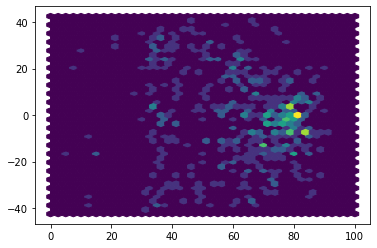

'Now working on Goals'

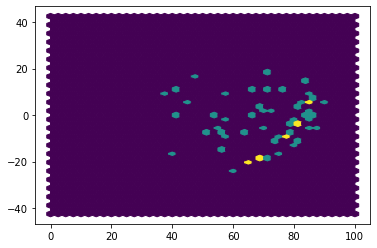

In [99]:
rink_size = [0, 100.0, -42.5, 42.5]
#plotting shots
shots_x_coordinates = shots_from_filtered_dataframe['coor_x_normalized'].to_numpy()
shots_y_coordinates = shots_from_filtered_dataframe['coor_y_normalized'].to_numpy()

#creating a hexbin plot to find the density of the attempted shots
shots_hexbin_plot =  plt.hexbin(shots_x_coordinates, shots_y_coordinates, gridsize=40, extent=rink_size)
#finding the centres of each hexbin 
shots_hexbin_offsets = shots_hexbin_plot.get_offsets();
#finding the values of the hexagons
shots_hexbin_values = shots_hexbin_plot.get_array();
plt.show()
display("Now working on Goals")
#plotting goals
goals_x_coordinates = goals_from_filtered_dataframe['coor_x_normalized'].to_numpy()
goals_y_coordinates = goals_from_filtered_dataframe['coor_y_normalized'].to_numpy()
goals_hexbin_plot =  plt.hexbin(goals_x_coordinates, goals_y_coordinates, gridsize=40, extent=rink_size)
goals_hexbin_offsets = goals_hexbin_plot.get_offsets()
goals_hexbin_values = goals_hexbin_plot.get_array();
plt.show()

[0, 100, -42.5, 42.5]
876 [90.00000008  1.84782609]
881 [90.00000008 20.32608696]
1821 [91.25000008 -7.39130435]


/var/folders/f7/3hptwq1j75nc45cd5svs7y0h0000gn/T/ipykernel_26710/2837398984.py:51: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  hex = RegularPolygon((x_trans+v[0]*scalingx,


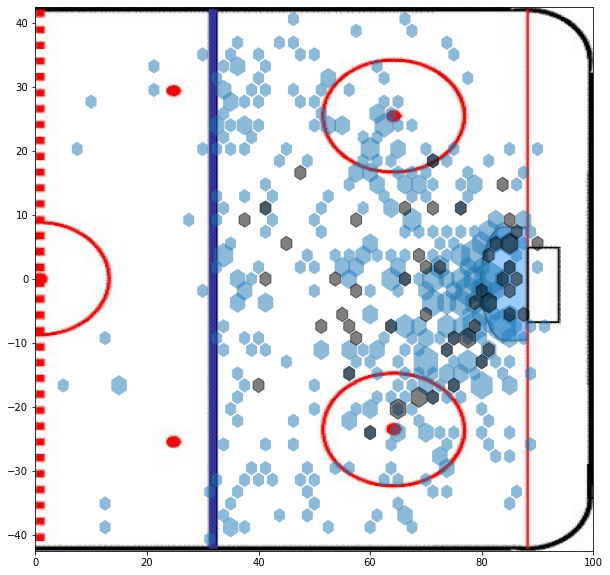

In [120]:
figure = plt.figure(figsize = (10,10))
figure_subplot = figure.add_subplot(111)
figure_subplot.set_ylim(ymin = -42.5, ymax = 42.5)
figure_subplot.set_xlim(xmin = 0.0, xmax = 100)

rink_image = Image.open('NHL-Rink-Half.jpeg') #simple_rink_grey.jpeg or #NHL-Rink-Wiki.png
printed = plt.imshow(rink_image, extent = [0, 100, -42.5, 42.5 ], aspect='auto') #NHL-Rink-Half.jpeg

for i,v in enumerate(shots_hexbin_offsets):
    if shots_hexbin_values[i] < 1:
        continue       
    scaled_league_shot_frequency = shots_hexbin_values[i] / max(shots_hexbin_values)
    radius = 3 * math.sqrt(scaled_league_shot_frequency)
    hex = RegularPolygon((x_trans+v[0]*scalingx, 
      y_trans+v[1]*scalingy),numVertices=6, radius=radius,
      orientation=np.radians(0),alpha=0.5, edgecolor=None)
    figure_subplot.add_patch(hex)
    
for i,v in enumerate(goals_hexbin_offsets):
    if goals_hexbin_values[i] < 1:
        continue
    scaled_league_goal_frequency = goals_hexbin_values[i]/max(shots_hexbin_values)
    radius = S*math.sqrt(scaled_league_goal_frequency)
#     translations we found earlier
   
   # Normalize the shot frequency data between 0-1
   # Scale the hexagon size based on shot frequency
   # Finally we will plot the hexagon including the scaling and
    hex = RegularPolygon((x_trans+v[0]*scalingx, 
      y_trans+v[1]*scalingy),numVertices=6, radius=radius,
      orientation=np.radians(0),alpha=0.5, edgecolor='Black', color='Black')
    figure_subplot.add_patch(hex)    

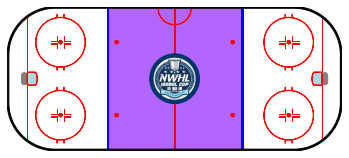

In [79]:
from hockey_rink import NWHLRink
rink = NWHLRink(x_shift=100, y_shift=42.5, nzone={"length": 80})
ax = rink.draw()